In [1]:
# Dependencies and Setup
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
import matplotlib.pyplot as plt
from scipy import stats

# Census API Key
c = Census(census_key, year=2017)
gmaps.configure(api_key=gkey)

In [2]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_data = c.acs5.get(("NAME","B01003_001E", "B19013_001E","B19301_001E","B17001_002E","B23025_005E",), {
                         'for': 'county:*'})



In [3]:
# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"NAME": "County Name","B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment Count",
                                      "county": "County","state":"State"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["Unemployment Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame

census_pd['FIPS Code'] = census_pd['State'].astype(str) + census_pd['County'].astype(str)
census_pd = census_pd[["FIPS Code","County", "State","County Name","Population","Household Income","Per Capita Income","Poverty Count","Poverty Rate","Unemployment Count", "Unemployment Rate"]]
census_pd.head()

,FIPS Code,County,State,County Name,Population,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Count,Unemployment Rate
0,72047,047,72,"Corozal Municipio, Puerto Rico",34933.0,14752.0,7887.0,19146.0,54.807775,3296.0,9.435205
1,72095,095,72,"Maunabo Municipio, Puerto Rico",11297.0,17636.0,8830.0,5945.0,52.624591,735.0,6.506152
2,72111,111,72,"Peñuelas Municipio, Puerto Rico",21661.0,16868.0,7983.0,12379.0,57.148793,1601.0,7.391164
3,72113,113,72,"Ponce Municipio, Puerto Rico",148863.0,16561.0,10775.0,75187.0,50.507514,7013.0,4.711043
4,72131,131,72,"San Sebastián Municipio, Puerto Rico",38970.0,14275.0,8072.0,21472.0,55.098794,3307.0,8.486015


In [4]:
len(census_pd)

3220

In [5]:
# File to Load
CDC_Data = "CDC_Data.csv"

# Read CDC File and store into Pandas data frame and format/reorder/rename
CDC_Table = pd.read_csv("CDC_Data.csv", encoding="ISO-8859-1",converters={'STCOUNTYFP': '{:0>5}'.format})
CDC_Table['STCOUNTYFP'] = CDC_Table.astype({"STCOUNTYFP": str})
CDC_Table = CDC_Table.rename(columns={"STCOUNTYFP": "FIPS Code"})


#Replace all values that say "missing" with 0 and convert to int
CDC_Table['Deaths'] = CDC_Table['Deaths'].replace({'Missing': '0'})
CDC_Table['Deaths'] = CDC_Table['Deaths'].astype(int)


In [6]:
#Merge census dataframe and CDC dataframe using FIPS code as the index, drop any N/A values
new_merged_df = pd.merge(census_pd,CDC_Table,how='outer',on='FIPS Code')
new_merged_df = new_merged_df.dropna(how='any')

#Calculate Deaths per 100K people and add column to dataframe
new_merged_df['Per 100K'] = 100000 * \
     new_merged_df['Deaths'].astype(int) / new_merged_df['Population_y'].astype(int)

new_merged_df.head()

,FIPS Code,County_x,State,County Name,Population_x,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Count,Unemployment Rate,County_y,Deaths,Population_y,Crude Rate,% of Total Deaths,Per 100K
84,01073,073,01,"Jefferson County, Alabama",659460.0,49321.0,29456.0,113368.0,17.191035,25044.0,3.797653,"Jefferson County, AL",167.0,659197,25.3,0.40%,25.333853
97,01117,117,01,"Shelby County, Alabama",208721.0,74063.0,35330.0,17127.0,8.205691,4650.0,2.227854,"Shelby County, AL",27.0,213605,12.6,0.10%,12.640154
98,01115,115,01,"St. Clair County, Alabama",86937.0,53483.0,24686.0,11656.0,13.407410,2354.0,2.707708,"St. Clair County, AL",15.0,88199,Unreliable,0.00%,17.006996
100,01003,003,01,"Baldwin County, Alabama",203360.0,52562.0,29364.0,23728.0,11.667978,5215.0,2.564418,"Baldwin County, AL",19.0,212628,Unreliable,0.00%,8.935794
101,01043,043,01,"Cullman County, Alabama",81703.0,40997.0,21857.0,13157.0,16.103448,1962.0,2.401381,"Cullman County, AL",12.0,82755,Unreliable,0.00%,14.500634


In [ ]:
# Store 'Lat' and 'Lng' into  locations 
counties = new_merged_df['County Name'].astype(list)


lat = []
lng = []
counter = 0
print(f'Beginning Data Retrieval')
print(f'-----------------------------')
# Extract latitude and longitude by feeding county name into google maps API
for county in counties:
    target_url = (f'https://maps.googleapis.com/maps/api/geocode/json?address={county}&key={gkey}')
    geo_data = requests.get(target_url).json()
    #append latitude and longitude for every county to lists above
    lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    lng.append(geo_data["results"][0]["geometry"]["location"]["lng"])
    counter += 1
    print(f'Processing record {counter} | {county}')
print(f'-----------------------------')
print(f'Data Retrieval Complete')
print(f'-----------------------------')

#Zip two lists together to form new dataframe for county coordinates
list_of_counties = list(zip(lat, lng))
counties_df = pd.DataFrame(list_of_counties)


#Convert datatype of coordinates to float

coordinates = counties_df.astype(float)

#Save results down to CSV as the google API takes several minutes to extract data
coordinates.to_csv("coordinates.csv", encoding="utf-8", index=False)

In [7]:
#reimport csv as new variable so we don't have to run the data extract every single time
coordinates_csv = pd.read_csv("coordinates.csv", dtype="float", encoding="utf-8")

In [8]:
#Convert the Opioid Deaths per 100K column of merged df to a float list
deaths_100K = new_merged_df["Per 100K"].astype(float)

In [9]:
#Google heatmaps using lat/long coordinates above weighted by deaths per 100K people, dynamic scaling (default intensity)
fig = gmaps.figure()
colors = ("maroon","red","yellow","green","blue","teal")
heat_layer = gmaps.heatmap_layer(coordinates_csv, weights=deaths_100K, 
                                 dissipating=False,
                                 point_radius = 0.5,opacity=0.5)


In [10]:
 # Convert number of deaths per county to a list
deaths_list = new_merged_df["Deaths"].tolist()

In [11]:
# Create death symbol layer and infobox which contains deaths in that county. Still haven't figured out how to 
#loop county name into the info box
deaths_layer = gmaps.symbol_layer(
    coordinates_csv, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=1,
    info_box_content=[f"2017 Opioid Related Deaths: \n{row}" for row in deaths_list])

In [12]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(deaths_layer)

fig

Figure(layout=FigureLayout(height='420px'))

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


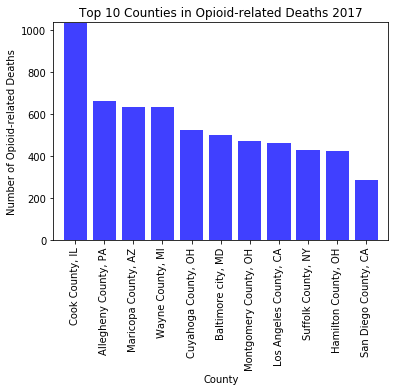

In [13]:
#Create bar graph for top 10 cities with greatest amount of Opioid-related Deaths plus San Diego
#sort CDC dataframe based on number of deaths and create dataframe
sorted_deaths_df = CDC_Table.sort_values("Deaths", ascending=False)
top_10_df_deaths = sorted_deaths_df.head(10)

#Search for San Diego info
sd_df = CDC_Table[CDC_Table['County'] == 'San Diego County, CA']
sd_df['Deaths'] = sd_df['Deaths'].astype(int)
#Join San Diego with top 10
top_10_df_deaths = top_10_df_deaths.append(sd_df)


#Create x ticks using list
x_axis = np.arange(0, len(top_10_df_deaths))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.title("Top 10 Counties in Opioid-related Deaths 2017")
plt.xlabel("County")
plt.ylabel("Number of Opioid-related Deaths")

plt.xlim(-0.75, len(top_10_df_deaths)-.25)
plt.ylim(0, max(top_10_df_deaths['Deaths']) + 5)

plt.bar(x_axis, top_10_df_deaths['Deaths'], facecolor="blue", alpha=0.75, align="center")
plt.xticks(tick_locations, top_10_df_deaths['County'],rotation=90)
plt.savefig("BarDeaths.png",bbox_inches = 'tight')

plt.show()


C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


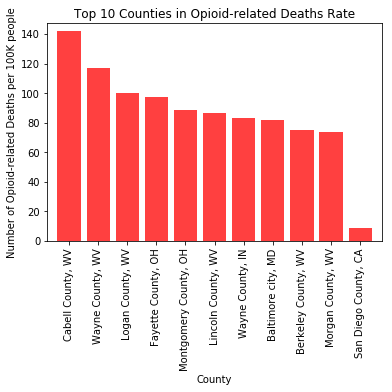

,FIPS Code,County_x,State,County Name,Population_x,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Count,Unemployment Rate,County_y,Deaths,Population_y,Crude Rate,% of Total Deaths,Per 100K
3080,54011,011,54,"Cabell County, West Virginia",96100.0,37816.0,24646.0,21376.0,22.243496,2304.0,2.397503,"Cabell County, WV",135.0,94958,142.2,0.30%,142.168116
3043,54099,099,54,"Wayne County, West Virginia",41063.0,38905.0,20582.0,8484.0,20.660936,1394.0,3.394784,"Wayne County, WV",47.0,40153,117.1,0.10%,117.052275
3083,54045,045,54,"Logan County, West Virginia",34428.0,37859.0,21074.0,7593.0,22.054723,1565.0,4.545719,"Logan County, WV",33.0,32925,100.2,0.10%,100.227790
2161,39047,047,39,"Fayette County, Ohio",28659.0,44289.0,24013.0,4944.0,17.251125,836.0,2.917059,"Fayette County, OH",28.0,28752,97.4,0.10%,97.384530
2202,39113,113,39,"Montgomery County, Ohio",531987.0,47045.0,27602.0,92085.0,17.309634,20849.0,3.919081,"Montgomery County, OH",472.0,531542,88.8,1.00%,88.798251
3036,54043,043,54,"Lincoln County, West Virginia",21241.0,37075.0,19321.0,5270.0,24.810508,566.0,2.664658,"Lincoln County, WV",18.0,20825,Unreliable,0.00%,86.434574
782,18177,177,18,"Wayne County, Indiana",66972.0,41813.0,23895.0,11727.0,17.510303,2033.0,3.035597,"Wayne County, IN",55.0,66185,83.1,0.10%,83.100400
1285,24510,510,24,"Baltimore city, Maryland",619796.0,46641.0,28488.0,133793.0,21.586619,30749.0,4.961149,"Baltimore city, MD",499.0,611648,81.6,1.00%,81.582871
3049,54003,003,54,"Berkeley County, West Virginia",111610.0,59480.0,27658.0,14353.0,12.859959,4741.0,4.247827,"Berkeley County, WV",86.0,114920,74.8,0.20%,74.834668
3035,54065,065,54,"Morgan County, West Virginia",17510.0,46346.0,24026.0,1920.0,10.965163,888.0,5.071388,"Morgan County, WV",13.0,17686,Unreliable,0.00%,73.504467


In [14]:
#Create bar graph for top 10 cities with greatest amount of Opioid-related Deaths per 100K plus San Diego
#sort CDC dataframe based on number of deaths per 100K and create dataframe
new_merged_df['Per 100K'] = new_merged_df['Per 100K'].astype(float)
sorted_deathrate_df = new_merged_df.sort_values("Per 100K", ascending=False)
top_10_df_rate = sorted_deathrate_df.head(10)


#Search for San Diego info
sd_rate_df = new_merged_df[new_merged_df['County_y'] == 'San Diego County, CA']
sd_rate_df['Per 100K'] = sd_rate_df['Per 100K'].astype(float)
#Join San Diego with top 10
top_10_df_rate = pd.concat([top_10_df_rate, sd_rate_df])

#Create x ticks using list
x_axis = np.arange(0, len(top_10_df_rate))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.title("Top 10 Counties in Opioid-related Deaths Rate")
plt.xlabel("County")
plt.ylabel("Number of Opioid-related Deaths per 100K people")

plt.xlim(-0.75, len(top_10_df_deaths)-.25)
plt.ylim(0, max(top_10_df_rate['Per 100K']) + 5)

plt.bar(x_axis, top_10_df_rate['Per 100K'], facecolor="red", alpha=0.75, align="center")
plt.xticks(tick_locations, top_10_df_rate['County_y'],rotation=90)
plt.savefig("BarDeathRate.png",bbox_inches = 'tight')
plt.show()
top_10_df_rate

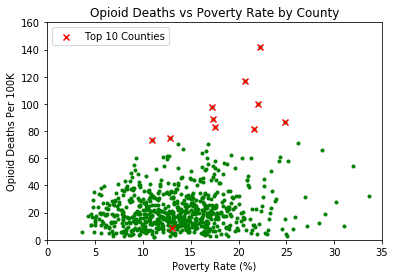

In [21]:
#Scatterplot to see relationship between poverty rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad have an abnormally high poverty rate?
poverty_rate = new_merged_df['Poverty Rate'].tolist()
death_scatter = new_merged_df['Per 100K'].tolist()
top_10_df_rate_poverty = top_10_df_rate['Poverty Rate'].tolist()
top_10_df_rate_deaths = top_10_df_rate['Per 100K'].tolist()

#Create scatter plot and legend
plt.scatter(poverty_rate, death_scatter, marker=".", color="green")
plt.scatter(top_10_df_rate_poverty, top_10_df_rate_deaths, marker="x", color="red",label = "Top 10 Counties")
plt.title("Opioid Deaths vs Poverty Rate by County")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Opioid Deaths Per 100K")
plt.xlim(0,35)
plt.ylim(0,160)
plt.legend(loc = "upper left", scatterpoints=1, fontsize=10,fancybox=True)
plt.savefig("ScatterPoverty.png")
plt.show()

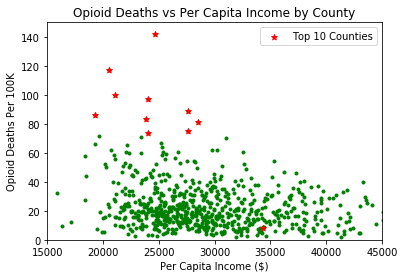

In [24]:
#Scatterplot to see relationship between unemployment rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad suffer from low income and are poor?

percapita_rate = new_merged_df['Per Capita Income'].tolist()
income_scatter = new_merged_df['Per 100K'].tolist()
top_10_df_rate_percap = top_10_df_rate['Per Capita Income'].tolist()
top_10_df_rate_deaths = top_10_df_rate['Per 100K'].tolist()

#Create scatter plot and legend
plt.scatter(percapita_rate, income_scatter, marker=".", color="green")
plt.scatter(top_10_df_rate_percap, top_10_df_rate_deaths, marker="*", color="red",label = "Top 10 Counties")
plt.title("Opioid Deaths vs Per Capita Income by County")
plt.xlabel("Per Capita Income ($)")
plt.ylabel("Opioid Deaths Per 100K")
plt.xlim(15000,45000)
plt.ylim(0,150)
plt.legend(loc = "upper right", scatterpoints=1, fontsize=10,fancybox=True)
plt.savefig("ScatterPerCapita.png")
plt.show()

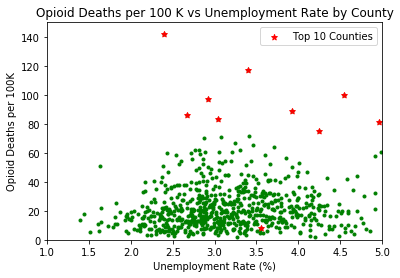

In [23]:
#Scatterplot to see relationship between unemployment rate and opioid deaths per 100K people. 
#Do the counties where the epidemic is particularly bad suffer from high unemployment?
unemployment_rate = new_merged_df['Unemployment Rate'].tolist()
income_scatter = new_merged_df['Per 100K'].tolist()

top_10_df_rate_unemp = top_10_df_rate['Unemployment Rate'].tolist()
top_10_df_rate_deaths = top_10_df_rate['Per 100K'].tolist()

#Create scatter plot and legend
plt.scatter(unemployment_rate, income_scatter, marker=".", color="green")
plt.scatter(top_10_df_rate_unemp, top_10_df_rate_deaths, marker="*", color="red",label = "Top 10 Counties")
plt.title("Opioid Deaths per 100 K vs Unemployment Rate by County")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Opioid Deaths per 100K")
plt.xlim(1,5)
plt.ylim(0,150)
plt.legend(loc = "upper right", scatterpoints=1, fontsize=10,fancybox=True)
plt.savefig("ScatterUnemployment.png")
plt.show()